In [1]:
import numpy as np
import scipy.stats as stats
from particles.kalman import Kalman, LinearGauss
from particles.core import SMC, multiSMC, FeynmanKac
import particles.state_space_models as ssms
from sdes.auxiliary_bridges import LocalLinearOUProp 
from sdes.sdes import OrnsteinUhlenbeck
from sdes.tools import struct_array_to_array, plot_simulations
from sdes.feynman_kac import BootstrapDA, ForwardGuidedDA
import matplotlib.pyplot as plt
import seaborn as sb

In [36]:
import particles
import scipy
import matplotlib

In [37]:
np.__version__, scipy.__version__, particles.__version__, matplotlib.__version__

('1.24.3', '1.10.1', '0.3alpha', '3.7.1')

Consider the Ornstein-Uhlenbeck process in one-dimension:

$$dV(s) = -\rho V(s) ds + \phi dW(s) \qquad V(0) = 0.$$

We assume for simplicity that $\Delta s = 1$, and we define each observation density $p_t(y_t|v_t)$ to be linear, Gaussian:

$$Y_t |V_t = v_t \sim \mathcal{N}(v_t, \eta^2)$$

We have parameter $\theta = (\rho, \phi, \eta^2)$. This is a linear SDE, with tractable transition density $p_t(v_t|v_{t-1})$, given by:

$$V_t|V_{t-1} = v_{t-1} \sim \mathcal{N}(e^{-\rho \Delta s}v_{t-1}, \frac{\phi^2}{2\rho}(1 - e^{-2\rho \Delta s}))$$

Thus, the random variables $(V_{1:T}, Y_{1:T})$ form a linear, Gaussian state space model, and it is possible to derive analytically the filtering and smoothing distributions, through Kalman filtering and smoothing. One can also implement particle filters/smoothers on discrete space, without data augmentation, with the optimal proposal being analytically tractable. Finally, the data augmentation approaches outlined in the contribution can be used.

We define the unknowns in this model below:

We fix parameter values $\theta = (\rho, \phi, \eta^2) = (0.2, 0.3, 0.01^2)$

In [2]:
Delta_s = 1.; rho = 0.2; phi = 0.3; eta = 0.01
T = 100; N = 1000 # Length of the data #Number of particles for pfs
ou_params = {'rho': rho, 'phi': phi}
ou_model_params = {**ou_params, 'eta': 0.01}
linear_gauss_params = {'sigmaY': eta,
                       'rho': np.exp(-rho*Delta_s),
                       'sigmaX': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s))),
                       'sigma0': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s)))
                      }

In [3]:
OU = OrnsteinUhlenbeck(**ou_params)
N = 1000; num = 100000
OU_sims = OU.simulate(N, 0., t_start=0., t_end=1., num=num, milstein=False)
# np.mean(OU_sims['1.0']), np.var(OU_sims['1.0']), linear_gauss_params['sigmaX'] ** 2

We test the implementation of the `LocalLinearOuProp` proposal SDE, so that we are sure that everything is correct.

The local linear OU proposal, should be an SDE, with drift given by: 

$b^{\rightarrow}(t, x) =  b(t, x) + \sigma(t, x)\sigma^T(t, x)\nabla_v [\tilde{\rho}_{y_1}(t, x)]$

Further, we assume that $y_1 = 1.$

$\tilde{\rho}_{y_1}(t, x)$ is the distribution of $Y_1 | X_t = x_t$, which is given by:

$$Y_1 | X_t = x_t \sim \mathcal{N}(A(1-t)x_t + B(1-t), C(1-t) + \eta^2)$$

Where we have 

- $A(t) = e^{-\rho * t}$
- $B(t) = 0.$
- $C(t) = \frac{\phi^2}{2\rho}(1 - e^{-2\rho t})$

Therefore, the expression $\nabla_x [\tilde{\rho}_{y_1}(t, x)]$ in this case, is given by:

$$\nabla_x [\tilde{\rho}_{y_1}(t, x)] = A(1-t) \times \frac{y_1 - A(1-t)x - B(1-t)}{C(1-t) + \eta^2}$$

In [23]:
def a(t):
    return np.exp(-rho*t)

def c(t):
    return (phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*t))

def custom_grad_log_py(t, x, y_1):
    return a(1-t) * (y_1 - a(1-t)*x)/(c(1-t) + eta ** 2)

def custom_opt_ou_drift(t, x, y_1):
    return -rho*x + (phi ** 2) * custom_grad_log_py(t, x, y_1) 

def custom_opt_ou_sigma(t, x):
    return phi

def test_ou_proposal():
    Delta_s = 1.; rho = 0.2; phi = 0.3; eta = 0.01
    T = 100; N = 1000 # Length of the data #Number of particles for pfs
    ou_params = {'rho': rho, 'phi': phi}
    ou = OrnsteinUhlenbeck(**ou_params)
    y_1 = 1.
    ou_opt_proposal = LocalLinearOUProp(OU, 0., 1., y_1, eta ** 2)
    ou_opt_proposal.build_linear_sde(0.)
    x_s = np.arange(0, 20, dtype=np.float64); t=0.5
    assert np.all(np.isclose(ou_opt_proposal.b(t, x_s), custom_opt_ou_drift(t, x_s, y_1)))
    assert np.all(np.isclose(ou_opt_proposal.sigma(t, x_s), custom_opt_ou_sigma(t, x_s)))

test_ou_proposal()

In [5]:
LGSSM = LinearGauss(**linear_gauss_params)
x, y = LGSSM.simulate(T) # Generate synthetic data


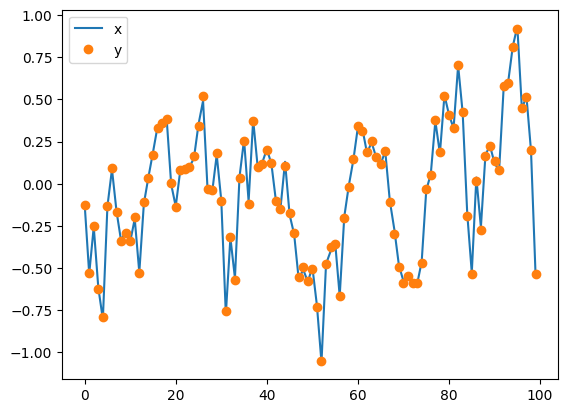

In [19]:
x_arr = np.array([arr[0] for arr in x])
y_arr = np.array([arr[0] for arr in y])
t_arr = np.arange(0, 100)
plt.plot(t_arr, x_arr, label='x')
plt.plot(t_arr, y_arr, 'o', label='y');
plt.legend()
plt.show()

In [25]:
tspan = np.linspace(0.0, 1.0, 5001)
x0 = 0.0

def f(x, t):
    return custom_opt_ou_drift(t, x, y)

def g(x, t):
    return custom_opt_ou_sigma(t, x)

result = sdeint.itoint(f, g, x0, tspan)

SDEValueError: y0 and f have incompatible shapes.

In [7]:
fg_da_fk = ForwardGuidedDA(y, **ou_params)
fg_da_fk.num = 5000
guided_ou_sims = fg_da_fk.M0(1000)

In [8]:
s_11 = linear_gauss_params['sigmaX'] ** 2
s_22 = s_11 + eta ** 2

mu_cond = s_11*(y[0])/s_22
s_cond = s_11 - (s_11 ** 2)/s_22

In [9]:
np.sqrt(s_cond)

0.009993266263632826

In [10]:
np.mean(guided_ou_sims['1.0']), np.std(guided_ou_sims['1.0'], ddof=1)

(-0.12364166242556782, 0.010447323727992201)

In [20]:
np.sqrt(s_cond)

0.009993266263632826

In [11]:
mu_cond, np.sqrt(s_cond)

(array([-0.12393725]), 0.009993266263632826)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

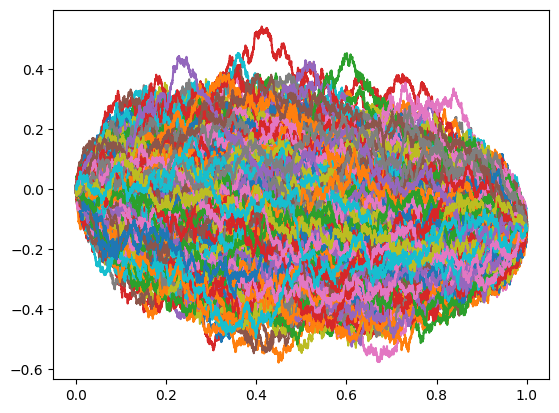

In [12]:
plot_simulations(guided_ou_sims)

In [13]:
# Discrete Time FK
bootstrap_fk = ssms.Bootstrap(ssm=LGSSM, data=y)
guided_fk = ssms.GuidedPF(ssm=LGSSM, data=y)
auxiliary_fk = ssms.AuxiliaryPF(ssm=LGSSM, data=y)

# Continuous Time FK
bootstrap_da_fk = BootstrapDA(y, **ou_params)
forward_proposal_fk = ForwardGuidedDA(y, **ou_params)

#Particle Filters in Discrete Time
bootstrap_pf = SMC(fk=bootstrap_fk, N=N, store_history=True)
guided_pf = SMC(fk=guided_fk, N=N, store_history=True)
auxiliary_pf = SMC(fk=auxiliary_fk, N=N, store_history=True)

#Particle Filters in Continuous Time
bootstrap_da_pf = SMC(fk=bootstrap_da_fk, N=N, store_history=True)
forward_proposal_pf = SMC(fk=forward_proposal_fk, N=N, store_history=True)

bootstrap_pf.run() 
guided_pf.run() #Uses the optimal proposal
auxiliary_pf.run() #Uses the optimal auxiliary weight

bootstrap_da_pf.run()  # Bootstrap filter that uses simulations from the SDE
forward_proposal_pf.run() # Guided filter that uses log girsanov weights 


# Kalman Filter benchmark
kf = Kalman(ssm=LGSSM, data=y)
kf.filter()

In [14]:
t = 30
mean = kf.filt[t].mean #Extract the mean
bootstrap_pf_hist = bootstrap_pf.hist # Particle History object
X, wgts = bootstrap_pf_hist.X[t], bootstrap_pf_hist.wgts[t] 

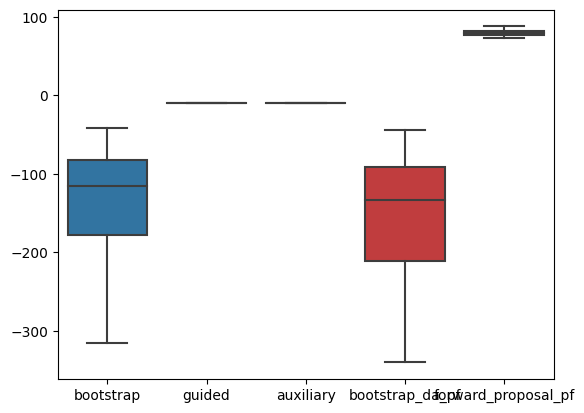

In [16]:
results = multiSMC(fk={'bootstrap': bootstrap_fk, 
                       'guided': guided_fk, 
                       'auxiliary': auxiliary_fk, 
                       'bootstrap_da_pf': bootstrap_da_fk, 
                       'forward_proposal_pf': forward_proposal_fk
                      }, 
                   N=100)
sb.boxplot(x=[r['fk'] for r in results], y=[r['output'].logLt for r in results]);

In [17]:
true_py = np.sum([a[0][0] for a in kf.logpyt])
true_py

-9.931468839360033